# 1. pyAp - Calculating apatite-melt exchange coefficients (Kd) and melt water concentration 

pyAp includes the melt hygrometry model (ApThermo) of Li and Costa (2020, GCA) with equations provided in ```pyApThermo.py```.

Applying this model requires known F, Cl (and H<sub>2</sub>O) concentrations in apatite, and the F and Cl concentrations in the melt (in equilibrium with apatite). 

This example file includes error estimation for the calculated water estimates using a monte carlo simuation algorithm, which is not available in our ApThermo webpage or excel versions.  

Please cite Li and Costa (2020) if you use this model:

 Li, W. & Costa, F. (2020) A thermodynamic model for F-Cl-OH partitioning between apatite and melt including non-ideal mixing and applications to constraining melt volatile budgets, Geochimica et Cosmochimica Acta 269, 203–222. https://doi.org/10.1016/j.gca.2019.10.035

### Import modules

import releavant modules.

In [1]:
import os, sys
# hack to allow scripts to be placed in subdirectories next to pyAp:
if not os.path.exists('pyAp') and os.path.exists('../pyAp'):
    sys.path.insert(1, os.path.abspath('..'))
from pathlib import Path
import math, random, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import warnings    

In [2]:
# Import pyAp modules
from pyAp import pyApthermo
from pyAp.pyAp_tools import ap_mc, load_animation

### Import data

!! Do NOT change the column headers in the template provided in the tutorial folder.

In [3]:
df = pd.read_excel('data_calc_water.xlsx')

extract parameters from the input data file by reading columm header names

In [4]:
order  = ['XF', 'XCL', 'T,C', 'MELTF', 'MELTCL', 'MELTCOMP']
data = df[order]  

### Calculate H<sub>2</sub>O in the melt from F and Cl in the apatite

The available water speciation models we have compiled are available in "pyAp/water_speciation.csv" and also implemented in `pyApThermo.py`. The existing models include:  
    `dacite` (Liu et al. 2004)  
    `alkali basalt` (Lasne et al. 2010)  
    `rhyolite` (Zhang et al. 1997)  
    `rhyolite_highP` (Hui et al. 2008)   
    `andesite` (Ni et al. 2009)  
    `andesite_highT` (Botcharnikov 2006).   
If no model was selected, the default model will choose `dacite` of Liu et al. (2004)

If you would like to use another water speciation model, please contact us.

You can use a Dataframe `apply()` function shown below for iteration through each row in the input data. To perform the calculation, we assin the data as an instance into the `Apthermo` class.

The water speciation model used in calculation is chosen from the available models according to the melt composition `MELTCOMP` column provided by users. To calculate the water concentration, you may switch `cal_H2O` to `True` (default is `False`), which will pass the data into `meltH2O()`. 8 results will be returned following the order as:  
MeltWater calculated from F and Cl,  Kds for OH-Cl, OH-F, Cl-F, and activitivy coefficient (gamma) of OH, F, and Cl. 

Below we give the example of calculating melt water, and export the result to a csv file.

In [5]:
results = pd.DataFrame()
list_result = data.apply(
    lambda row: pyApthermo.ApThermo(inputs=row[order], cal_H2O=True,cal_gamma=False).meltH2O(),axis=1
    )
results['MeltWater_calcfromF']  = [x[0] for x in list_result]
results['MeltWater_calcfromCl'] = [x[1] for x in list_result]
results['sample']               = df['sample']

results

,MeltWater_calcfromF,MeltWater_calcfromCl,sample
0,4.327077,3.373130,Ap1
1,1.465439,1.336840,Ap2
2,0.673665,0.590161,Ap3


save the results

In [6]:
fn = 'outputs_melt_water.csv'
results.to_csv(fn)

### Error integration from monte carlo simulation (MCS)

Below we give an example for MCS to integrate analytical errors from melt compositions, apatite composition, and temperature.

First, set the entry of MCS (number of runs); better to be larger than 1000.

In [7]:
mc = 1000

Create dataframe for collecting MCS results and extract raw data and their errors

In [8]:
ap_mc_collect = pd.DataFrame([])

comp = df[['XF', 'XCL', 'T,C', 'MELTF', 'MELTCL']]
std = df[['XF_SD', 'XCL_SD', 'T_SD','MELTF_SD', 'MELTCL_SD']]

MCS can be perfromed via a loop but that can be rather slow if the dataset is large. 

Here we use a built-in function `ap_mc()` to vectorize and expand the existing empty dataframe `ap_mc_collect` with MCS results. 

Feel free to use your own MCS algorithm if you want. 

In [9]:
for idx in range(len(df)):
    df_iter = ap_mc(comp, std, idx, mc)
    ap_mc_collect = ap_mc_collect.append(df_iter)

Apply the `meltH2O()` function to the expanded MCS dataframe. The melt water estimates are saved in the "ap_mc_collect" dataframe. 

Note that when MCS has a larger value, a runtime warning might appear, we suspended the warning by using `filterwarnings`. 
The calculated melt water compositions have been suspended to be lower than 16 (wt%).

In [10]:
warnings.filterwarnings("ignore")

ap_mc_collect.columns = comp.columns
ap_mc_collect['MELTCOMP'] = df.loc[df.index.repeat(mc)]['MELTCOMP']
ap_mc_collect['water_estimates'] = ap_mc_collect.apply(
    lambda row: pyApthermo.ApThermo(inputs=row[order], cal_H2O=True,cal_gamma=False).meltH2O(),axis=1
    )
ap_mc_collect['sample'] = df.loc[df.index.repeat(mc)]['sample']

In [11]:
results_mc = pd.DataFrame()
results_mc['MeltWater_calcfromF'] = [x[0] for x in ap_mc_collect['water_estimates']]   ## only take melt water estimates between 0 and 16wt%
results_mc['MeltWater_calcfromCl'] = [x[1] for x in ap_mc_collect['water_estimates']]  ## only take melt water estimates between 0 and 16wt%
results_mc['sample'] = ap_mc_collect.reset_index()['sample']

Display MCS results for each crystal

In [12]:
results_mc.groupby('sample').agg(['median', 'mean', 'std'])

MeltWater_calcfromF                     MeltWater_calcfromCl            \
                    median      mean       std               median      mean   
sample                                                                          
Ap1               4.323020  4.362345  0.764766             3.367485  3.624585   
Ap2               1.472153  1.472895  0.236625             1.347868  1.414629   
Ap3               0.672730  0.675322  0.168685             0.588964  0.621634   

                  
             std  
sample            
Ap1     1.322785  
Ap2     0.448814  
Ap3     0.236727

Calculate the median value for each crystal. If the distribution of MCS results is (nearly) gaussian (see kernel density plot below), a mean value could be used instead of median.

In [13]:
median_F = results_mc.groupby('sample')['MeltWater_calcfromF'].median()
median_Cl = results_mc.groupby('sample')['MeltWater_calcfromCl'].median()

1sd errors in results are calculated by taking half of the range between 84% and 16% of all MCS results. 

In [14]:
sd_F = results_mc.groupby('sample')['MeltWater_calcfromF'].transform(lambda s: (np.percentile(s, 84)-np.percentile(s, 16))/2).unique()
sd_Cl = results_mc.groupby('sample')['MeltWater_calcfromCl'].transform(lambda s: (np.percentile(s, 84)-np.percentile(s, 16))/2).unique()

In [15]:
results['MeltWater_Fmedian']   = [x for x in median_F]
results['MeltWater_F1sd']  = [x for x in sd_F]
results['MeltWater_F_error,100%']  = results['MeltWater_F1sd']/results['MeltWater_Fmedian']*100

results['MeltWater_Clmedian']  = [x for x in median_Cl]
results['MeltWater_Cl1sd'] = [x for x in sd_Cl]
results['MeltWater_Cl_error,100%']  = results['MeltWater_Cl1sd']/results['MeltWater_Clmedian']*100

plot MCS results

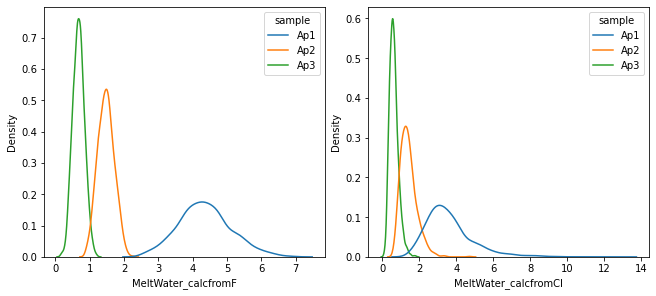

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9,4), constrained_layout=True)

sns.kdeplot(x = 'MeltWater_calcfromF', data=results_mc, hue='sample', ax = axes[0])
sns.kdeplot(x = 'MeltWater_calcfromCl', data=results_mc, hue='sample', ax = axes[1])

plt.show()